In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
df = pd.read_csv('/content/drive/MyDrive/combined_data_1.txt',header=None,names = ['Cust_Id', 'Rating'],usecols=[0,1])

In [56]:
df

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0
...,...,...
24058258,2591364,2.0
24058259,1791000,2.0
24058260,512536,5.0
24058261,988963,3.0


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Cust_Id  object 
 1   Rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [58]:
df.shape

(24058263, 2)

In [59]:
movie_count=df.isnull().sum()
movie_count

Cust_Id       0
Rating     4499
dtype: int64

In [60]:
customer_count=df['Cust_Id'].nunique()-movie_count
customer_count

Cust_Id    475257
Rating     470758
dtype: int64

In [61]:
rating_count=df['Cust_Id'].count()-movie_count
rating_count

Cust_Id    24058263
Rating     24053764
dtype: int64

In [62]:
stars = df.groupby('Rating')['Rating'].agg(['count'])
stars

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


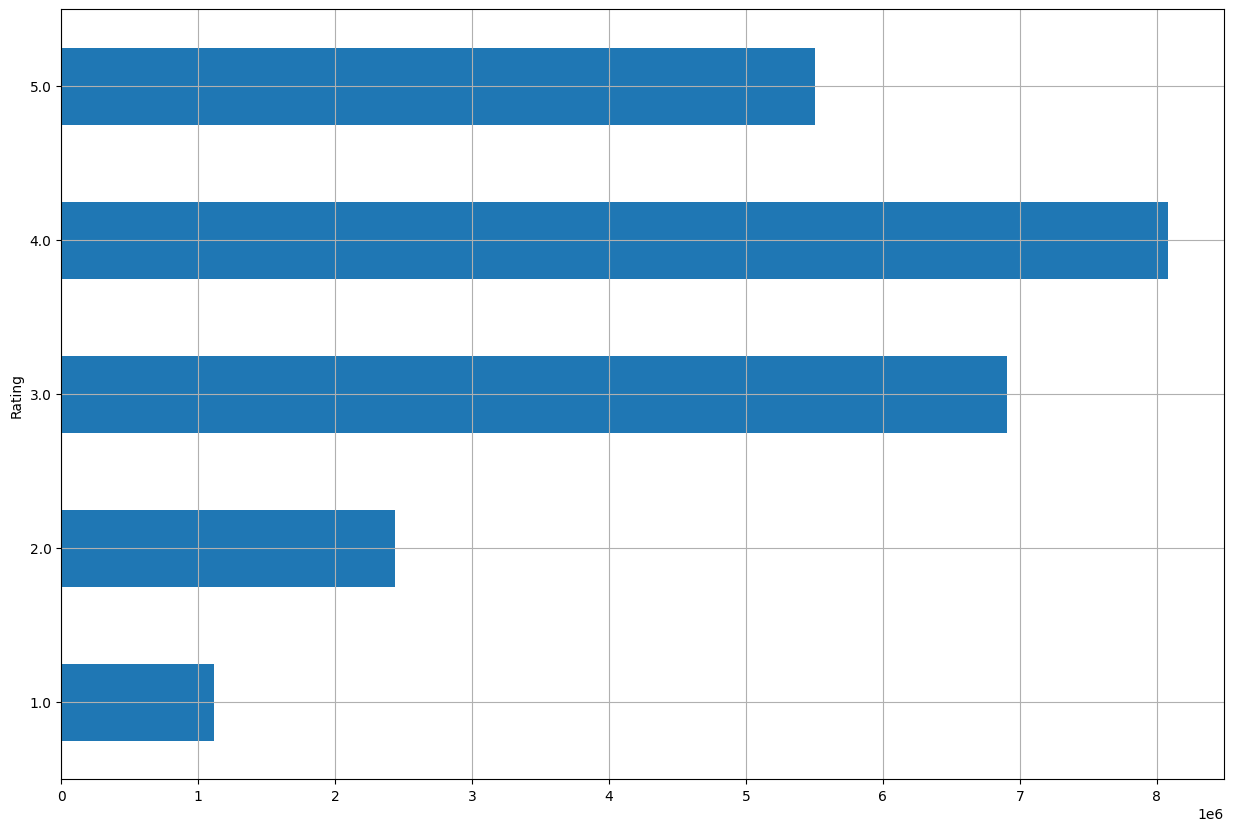

In [63]:
ax = stars.plot(kind='barh',legend=False, figsize=(15,10))
plt.grid(True)

In [64]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan

,Rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [65]:
df_nan = df_nan[df_nan['Rating']==True]
df_nan

,Rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [66]:
df_nan=df_nan.reset_index()

In [67]:
df_nan

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [68]:
df_nan.shape

(4499, 2)

In [69]:
movie_np = []
movie_id = 1
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length

last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [ ]:
df=df[pd.notnull(df['Rating'])]
df['Movie_Id']=movie_np.astype(int)
df['Cust_Id']=df['Cust_Id'].astype(int)
df.head()

Benchmarks

In [ ]:
f = ['count','mean']

dataset_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

In [ ]:
dataset_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f) #mean and count of customer id
dataset_cust_summary.index = dataset_cust_summary.index.map(int) #integer format
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7),0)
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index
print(f'Customer minimum times of review: {cust_benchmark}')

In [ ]:
print(f'Original Shape: {df.shape}')

In [ ]:
df = df[~df['Movie_Id'].isin(drop_movie_list)]

df = df[~df['Cust_Id'].isin(drop_cust_list)]

print('After Trim Shape: {}'.format(df.shape))

In [ ]:
df_title = pd.read_csv('movie_titles1.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])

df_title.set_index('Movie_Id', inplace = True)

In [ ]:
print (df_title.head(10))

In [ ]:
!pip install scikit-surprise

In [ ]:
import math
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
reader = Reader()

data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

To find all the movies rated as 5 stars by user with userId = 712664

In [ ]:
df_712664 = df[(df['Cust_Id'] == 712664) & (df['Rating'] == 5)]
df_712664 = df_712664.set_index('Movie_Id')
df_712664 = df_712664.join(df_title)['Name']
df_712664.head(10)

In [ ]:
user_712664 = df_title.copy()
user_712664 = user_712664.reset_index()
user_712664 = user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)
trainset = data.build_full_trainset()
svd.fit(trainset)
user_712664['Estimate_Score'] = user_712664['Movie_Id'].apply(lambda x: svd.predict(712664, x).est)
user_712664 = user_712664.drop('Movie_Id', axis = 1)
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)
print(user_712664.head(10))